# FVCOM - Forward tracking

The Finite Volume Community Ocean Model (FVCOM) is a prognostic, unstructured-grid, finite-volume, free-surface, 3D primitive equation coastal ocean circulation model written in ANSI FORTRAN 95 (Chen et al. 2003). *PyLag* includes support for reading in FVCOM outputs and using them to track the movement of particles in the simulated flow field. Here we demonstrate this functionality using outputs from an FVCOM simulation of circulation dynamics within the Tamar Estuary, at the border between Devon and Cornwall on the southwest coast of the United Kingdom. The focus is on forward tracking, meaning we follow particle movements forward in time. A [backtracking experiment](./fvcom_backward_tracking.ipynb) using outputs from the same FVCOM simulation described is described separately.

The FVCOM output files needed for the example can be [downloaded here](https://drive.google.com/open?id=15UX7Y9JnuLpnPAz700mzmzd917nTClxR). If you would like to run the code in this notebook interactively, download the data into a directory of your chooising. By default, the notebook will look for these files in the directory `${HOME}/data/pylag_doc`. To change this, simply update the *data_dir* path below.

In [1]:
import os

# Root directory for PyLag example input files
data_dir='{}/data/pylag_doc'.format(os.environ['HOME'])

## Background

For the example, we use outputs from the Western Channel Observatory operational forecast (WCOOF) model. The coastal high resolution forecast system WCOOF has been developed within the [MyCoast](http://mycoast-project.org/) Interreg project. It provides real-time (daily) short-term two day hydrodynamic 3D forecast of a range of physical parameters (currents, temperature, salinity and sea-level) and one day hindcasts. WCOOF consists of a combination of an ocean model, FVCOM (v4.3); an atmospheric model, WRF (v4.0);  and a local river forecast model all managed through the MetOffice scheduler ROSE. Along the open boundary, the model is forced by data from the CMEMS North West Shelf Monitoring Forecast Centre.

FVCOM solves the 3D momentum, continuity, temperature, salinity, and density equations by computing fluxes between unstructured triangular elements. Vertical turbulent mixing is modelled with the General Ocean Turbulence Model (GOTM) using a κ-ω formulation (Umlauf and Burchard, 2005) whilst horizontal mixing is parameterised through the Smagorinsky scheme with a coefficient of 0.1. The vertical grid in FVCOM is described in terrain following (sigma) coordinates where shallower areas resolve vertical structure with finer detail. 

The West Coast Observatory (WCO) model domain covers the Tamar estuary and nearshore area in the south-west of the UK between longitudes -4.81° E to -3.80° E and latitudes 49.72° N to 50.52° N.  It resolves the coastal intertidal areas which are present inside the estuarine area. A minimum depth of 20 cm determines the transition between wet and dry areas in intertidal slopes. A map of the model grid and bathymetry, centered on Plymouth Sound, is shown below. To make the plot, we leverage a small number of tools from the *processing* sub-package.

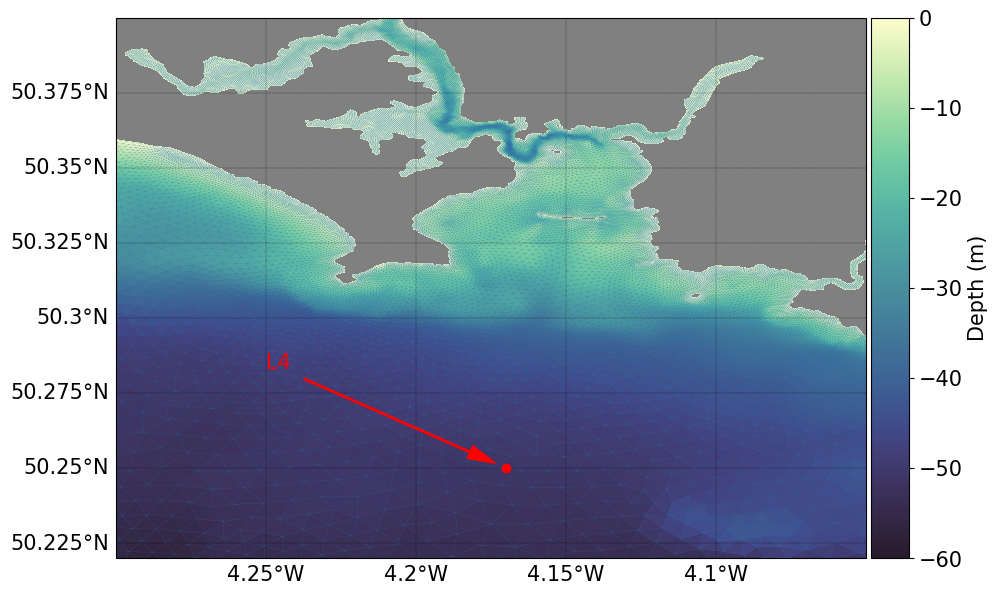

In [2]:
import warnings
import numpy as np
import matplotlib
from netCDF4 import Dataset
import cartopy.crs as ccrs

# Ensure inline plotting
%matplotlib inline

from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap

warnings.filterwarnings('ignore')

# Root directory for PyLag example input files
data_dir='{}/data/pylag_doc'.format(os.environ['HOME'])

# Grid metrics file
grid_metrics_file_name = '{}/fvcom_tamar_estuary_grid_metrics.nc'.format(data_dir)

# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
del(ds)

# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
extents = np.array([-4.3, -4.05, 50.22, 50.4], dtype=float)
plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=cmap)

# Overlay grid
plotter.draw_grid(ax, linewidth=0.1)

# Mark location of Station L4
plotter.scatter(ax, [-4.17], [50.25], marker='o', c='r')
x, y = ax.projection.transform_point(-4.17, 50.25, src_crs=ccrs.PlateCarree())
label = ax.annotate('L4', xy=(x, y), xytext=(0.2, 0.35), textcoords='axes fraction',
             arrowprops=dict(facecolor='red', edgecolor='red', width=1, headwidth=10, headlength=20, shrink=0.05),
             fontsize=font_size, color='red')


When making the above plot, grid information was read in from a [grid metrics](../documentation/overview.ipynb) file, which has been pre-generated for the purpose of running the example. Also shown in the figure is the location of the long-term monitoring site *Station L4*, which forms part of the [Western Channel Observatory](https://www.westernchannelobservatory.org.uk/).

<div class="alert alert-info">

**Note:**
    
Only a small part of the full domain is plotted. To see the full domain, you can remove the `extents` argument in the above code cell.

</div>

## Setting particle initial positions

We will create an initial position file in which to record [particle initial positions](../documentation/getting_started.ipynb). This will be read in by *PyLag*, and used to create the initial particle seed. The *processing* sub-package includes a number of tools to assist with the creation of particle initial position files. Specifically, it makes it possible to create any number of particle *release zones*, which are circular areas of a user defined size in which any number of particles can be placed. Here, we create a single release zone with a radius of 200 m which is located at the edge of Plymouth Sound. We will evenly distribute approximately 100 particles in the release zone. This will act as our *particle seed*. We will save the outputs in a file called `initial_positions.dat`, which will be saved in the sub-directory `input`. In turn, the `input` sub-directory will be created in a dedicated simulation directory `simulations/fvcom_forward`.

In [3]:
import os

from pylag.processing.coordinate import utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group

# Keep a copy of the cwd
cwd = os.getcwd()

# Create run directory
simulation_dir = '{}/simulations/fvcom_forward'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# The group ID of this particle set
group_id = 1

# Lat and lon coordiantes for the centre of the release zone
lat = 50.32
lon = -4.17

# Convert to UTM coordinates
epsg_code = '32630'
easting, northing, _ = utm_from_lonlat([lon], [lat], epsg_code=epsg_code)

# Release zone radius (m)
radius = 200.0

# Target number of particles to be released. Only a target,
# since we are evenly distributing particles in the release
# zone, which has no unique solution.
n_particles_target = 100

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [easting, northing],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = False)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Output filename
file_name = '{}/initial_positions.dat'.format(input_dir)

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           surface_release_zone.get_eastings(),
                                           surface_release_zone.get_northings(),
                                           surface_release_zone.get_depths())


To see the initial positions of particles, we can simply plot them. Note the ordered scattering of particles within the circular release zone, which is clearly visibile after zooming in on the release zone.

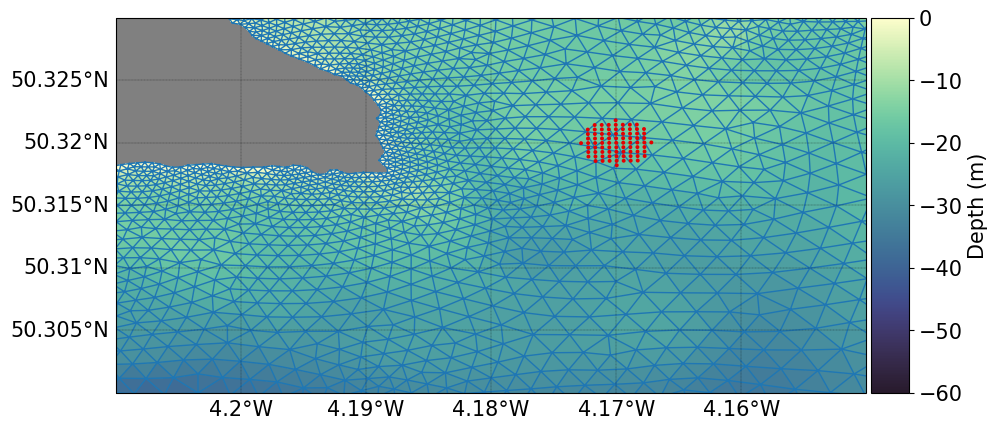

In [4]:
# Convert utm coords to degrees
lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
                             surface_release_zone.get_northings(),
                             epsg_code=epsg_code)

# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
extents = np.array([-4.21, -4.15, 50.30, 50.33], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0., cmap=cmap)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Plot particle initial positions
scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='none')

## Creating a FVCOM grid metrics file

When running with a new input dataset, it is necessary to generate a [grid metrics](../documentation/overview.ipynb) file. The grid metrics file holds information about the grid on which data are defined. *PyLag* reads this file in during model start up. The data is pre-generated, so that the grid information can be reused in later simulations using the same input dataset. This avoids incurring repeated costs associated with generating the data. As stated above, a grid metrics file for this example has been pre-generated; indeed, it was used to create the above plot of the domain's bathymetry. However, for the sake of completeness, we regenerate the grid metrics file so it is clear how this is done in an end-to-end example. To generate a new FVCOM grid metrics file, we need two types of file: an example FVCOM output file, and the file that lists the location of the domain's open boundary nodes.

In [5]:
from pylag.grid_metrics import create_fvcom_grid_metrics_file

# An example FVCOM output file
fvcom_file_name = '{}/fvcom_tamar_estuary_0001.nc'.format(data_dir)

# The file listing the location of open boundary nodes
obc_file_name = '{}/fvcom_tamar_estuary_obc.dat'.format(data_dir)

# The name of the output file
grid_metrics_file_name = '{}/grid_metrics.nc'.format(input_dir)

# Generate the file
create_fvcom_grid_metrics_file(fvcom_file_name, obc_file_name=obc_file_name,
                               grid_metrics_file_name=grid_metrics_file_name)

Creating FVCOM grid metrics file /users/modellers/jcl/code/git/PyLag/PyLag/doc/source/examples/simulations/fvcom_forward/input/grid_metrics.nc
Grid has 45 nodes on the open boundary


## Creating the run configuration file

When running applied examples, run configuration parameters are typically set in a [run configuration](../documentation/getting_started.ipynb) file. Examples of *PyLag* run configuration files can be found in PyLag's resources directory, which ships with the code. For this example, a run configuration file has been provided. The file includes lots of comments, so we won't print it's full contents here. Instead, we will use configparser to look at a few settings specific to the example. First, we read in the file, then we print out some of the key options for the run:

In [6]:
import configparser

config_file_name = './configs/fvcom_forward_template.cfg'

cf = configparser.ConfigParser()
cf.read(config_file_name)

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))

# Specify that this is a forward tracking experiment
print('Time direction: {}'.format(cf.get('SIMULATION', 'time_direction')))

# We will do a single run, rather than an ensemble run
print('Number of particle releases: {}'.format(cf.get('SIMULATION', 'number_of_particle_releases')))

# Use depth restoring, and restore particle depths to the ocean surface
print('Use depth restoring: {}'.format(cf.get('SIMULATION', 'depth_restoring')))
print('Restore particles to a depth of: {} m'.format(cf.get('SIMULATION', 'fixed_depth')))

# Specify that we are working with FVCOM in cartesian coordinates
print('Model name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'name')))
print('Coordinate system: {}'.format(cf.get('SIMULATION', 'coordinate_system')))

# Set the location of the grid metrics and input files
print('Data directory: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'data_dir')))
print('Path to grid metrics file: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file')))
print('File name stem of input files: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'data_file_stem')))
      
# Do an advection only run using a RK$ intergration scheme 
print('Numerical method: {}'.format(cf.get('NUMERICS', 'num_method')))
print('Iterative method: {}'.format(cf.get('NUMERICS', 'iterative_method')))

Start time: 2020-05-02 03:00:00
End time: 2020-05-02 18:00:00
Time direction: forward
Number of particle releases: 1
Use depth restoring: True
Restore particles to a depth of: 0.0 m
Model name: FVCOM
Coordinate system: cartesian
Data directory: 
Path to grid metrics file: 
File name stem of input files: fvcom_tamar_estuary_0
Numerical method: standard
Iterative method: Adv_RK4_3D


From the above options, it can be seen we hvae not yet specified a directory within which the model can find FVCOM output files, or the location of the grid metrics file. We will set these using `data_dir`, and save the new config file in the simulation directory. All other paths are relative, and can be left as they are.

In [7]:
cf.set('OCEAN_CIRCULATION_MODEL', 'data_dir', data_dir)
cf.set('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file', grid_metrics_file_name)

# Save a copy in the simulation directory
with open("{}/pylag.cfg".format(simulation_dir), 'w') as config:
    cf.write(config)

## Running the model

With the run configuration file saved, we can now run the example. While PyLag can be used interactivatly, it is most commonly launched from the command line like so:

In [8]:
# Change to the run directory
os.chdir('{}'.format(simulation_dir))

# Run the model
!{"python -m pylag.main -c pylag.cfg"}

# Return to the cwd
os.chdir(cwd)


Starting ensemble member 1 ...
Progress:
100% |###########################################|


## Visualising the result

With the model having run, the final step is to visulise the result. Here, we produce a simple plot of particle pathlines over the course of the simulation. Within the *config* file, we specified that outputs should be saved in an directory called `output`. To make the plot, we leverage plotting functionlity provided with the *processing* sub-package.

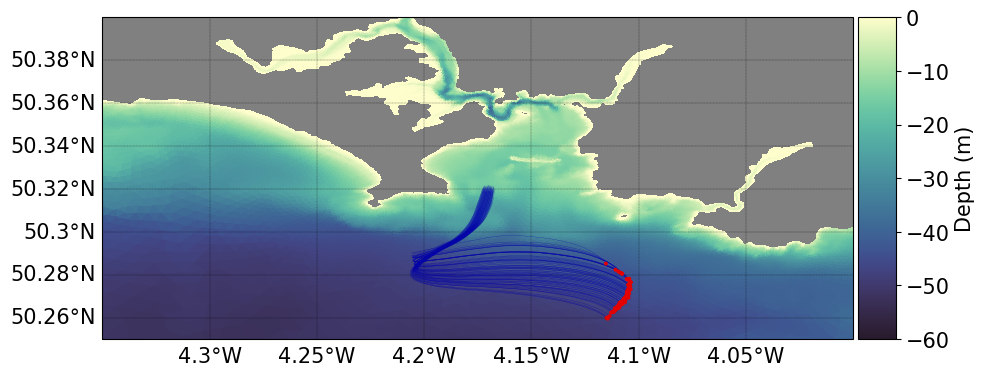

In [9]:
from datetime import timedelta

from pylag.processing.ncview import Viewer


file_name = '{}/output/pylag_1.nc'.format(simulation_dir)

# Time of flight
time_of_flight = timedelta(hours=15)

# Plot extents
extents = np.array([-4.35, -4.0, 50.25, 50.4], dtype=float)

fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot the bathymetry again. We'll overlay pathlines on top of this.
plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                   vmin=-60., vmax=0., cmap=cmap)

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=900)

# Get time index
date = viewer.date[0] + time_of_flight
time_index = viewer.date.tolist().index(date)
n_times = viewer.date[:time_index+1].shape[0]

# Convert positions into lons/lats
lons, lats = lonlat_from_utm(viewer('x')[time_index, :].squeeze(),
                             viewer('y')[time_index, :].squeeze(), epsg_code=epsg_code)

# Plot particle final positions
ax, scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='none')

# Convert all pathline coordinates into lons/lats
lons_paths, lats_paths = lonlat_from_utm(viewer('x')[:], viewer('y')[:], epsg_code=epsg_code)

# Add path lines
ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.15, alpha=1, color='#0504aa')

In the plot we can see particles moving out into the centre of the channel. Initially, particles form a relatively coherent collective, with shear dispersion only slowly causing particle pathlines to diverge. If we had run with turbulent mixing, particle pathlines would have diverged more quickly. A discussion of transport dynamics in this area can be found in Uncles et al (2020).

# References

.. footbibliography::

## References

Chen,  C.  H.  Liu,  R.  C.  Beardsley,  2003.  An  unstructured,  finite-volume,  three-dimensio nal, primitive  equation  ocean  model:  application  to  coastal  ocean  and  estuaries.J.  Atm.  &Oceanic Tech., 20, 159-186

Umlauf, L. Burchard, H., 2004. Second-order turbulence closure models for geophysical boundary layers. A review of recent work. Continental Shelf Research 25(7):795-827. DOI: 10.1016/j.csr.2004.08.004

Uncles, R. J., Clark, J. R., Bedington, M., Torres, R. 2020. “On sediment dispersal in the Whitsand Bay Marine  Conservation Zone: Neighbor to a closed dredge-spoil disposal site” in Marine Protected Areas: Evidence, Policy and Practise, ed Robert Clark and John Humphreys (Elsevier Inc.).